# Bio Subgraphs

Illustrate how KGTK can be used to compute subgraphs in bioinformatics.

The notebook shows how to extract a subgraph of `anatomical structure (Q4936952)` with `part of (P361)` and `has part (P527)` relations among them. It is important to include only q-nodes that are anatomical structures. When an anatomical structure includes parts that are not themselves anatomical structures, those parts that are not anatomical structures are not included in the graph.

A simple solution to the problem uses `instance of (P31)` to find anatomical structures and to query for their parts. This approach yields a small graph as many anatomical structures are not direct `instance of (P31)`, but rather instances of subclasses of `anatomical structure (Q4936952)`.

### Preamble: set up the environment and files used in the tutorial

In [1]:
import io
import os
import subprocess
import sys

import numpy as np
import pandas as pd
from IPython.display import display, HTML

from graph_tool.all import *

import papermill as pm

from kgtk.configure_kgtk_notebooks import ConfigureKGTK
from kgtk.functions import kgtk, kypher

In [2]:
# Parameters

kgtk_path = "/Users/pedroszekely/Documents/GitHub/kgtk"

# Folder on local machine where to create the output and temporary folders
input_path = "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215/data/"
input_path = "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2/"
output_path = "/Users/pedroszekely/Downloads/kypher/projects"
graph_cache_path = "/Users/pedroszekely/Downloads/kypher/wikidata.sqlite3.db"
project_name = "bio-subgraphs"

Our Wikidata distribution partitions the knowledge in Wikidata into smaller files that make it possible for you to pick and choose which files you want to use. Our tutorial KG is a subset of Wikidata, and is partitioned in the same way as the full Wikidata. The following is a partial list of all the files:

In [3]:
files = [
    "claims",
    "p279star"
]
ck = ConfigureKGTK(files, kgtk_path=kgtk_path)
ck.configure_kgtk(input_graph_path=input_path,
                  output_path=output_path,
                  graph_cache_path=graph_cache_path,
                  project_name=project_name,
                  debug=True
                 )

User home: /Users/pedroszekely
Current dir: /Users/pedroszekely/Documents/GitHub/kgtk-tutorial-files/use-cases
KGTK dir: /Users/pedroszekely/Documents/GitHub/kgtk
Use-cases dir: /Users/pedroszekely/Documents/GitHub/kgtk/use-cases


The KGTK setup command defines environment variables for all the files so that you can reuse the Jupyter notebook when you install it on your local machine.

In [4]:
ck.print_env_variables()

KGTK_OPTION_DEBUG: false
TEMP: /Users/pedroszekely/Downloads/kypher/projects/bio-subgraphs/temp.bio-subgraphs
GRAPH: /Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2/
EXAMPLES_DIR: /Users/pedroszekely/Documents/GitHub/kgtk/examples
kgtk: kgtk --debug
USE_CASES_DIR: /Users/pedroszekely/Documents/GitHub/kgtk/use-cases
STORE: /Users/pedroszekely/Downloads/kypher/wikidata.sqlite3.db
KGTK_GRAPH_CACHE: /Users/pedroszekely/Downloads/kypher/wikidata.sqlite3.db
OUT: /Users/pedroszekely/Downloads/kypher/projects/bio-subgraphs
kypher: kgtk --debug query --graph-cache /Users/pedroszekely/Downloads/kypher/wikidata.sqlite3.db
KGTK_LABEL_FILE: /Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//labels.en.tsv.gz
claims: /Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//claims.tsv.gz
p279star: /Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//derived.P279star.tsv.gz


In [5]:
ck.load_files_into_cache()

kgtk --debug query --graph-cache /Users/pedroszekely/Downloads/kypher/wikidata.sqlite3.db -i "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//claims.tsv.gz" --as claims  -i "/Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2//derived.P279star.tsv.gz" --as p279star  --limit 3
[2021-11-13 08:13:14 sqlstore]: DROP graph data table graph_1 from claims
[2021-11-13 08:51:23 sqlstore]: IMPORT graph directly into table graph_11 from /Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2/claims.tsv.gz ...
[2021-11-13 09:49:06 sqlstore]: DROP graph data table graph_4 from p279star
[2021-11-13 09:51:11 sqlstore]: IMPORT graph directly into table graph_12 from /Volumes/GoogleDrive/Shared drives/KGTK/datasets/wikidata-20210215-dwd-v2/derived.P279star.tsv.gz ...
[2021-11-13 09:57:45 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_11 AS graph_11_c1
     LIMIT ?
  PARAS: [3]
---------

In [ ]:
# best indexing for this notebook
# !kgtk --debug query -i claims --idx mode:graph -i p279star --idx mode:monograph

In [12]:
# how to. drop existing indices to create new ones
!kgtk --debug query -i claims --idx mode:clear mode:graph -i p279star --idx mode:clear mode:monograph --limit 5

[2021-11-13 12:50:59 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_11 AS graph_11_c1
     LIMIT ?
  PARAS: [5]
---------------------------------------------
[2021-11-13 12:50:59 sqlstore]: DROP INDEX "graph_11_label_idx"
[2021-11-13 12:52:09 sqlstore]: DROP INDEX "graph_11_node2_idx"
[2021-11-13 12:53:56 sqlstore]: CREATE INDEX "graph_11_node1_label_node2_idx" ON "graph_11" ("node1", "label", "node2")
[2021-11-13 13:13:19 sqlstore]: ANALYZE "graph_11_node1_label_node2_idx"
[2021-11-13 13:15:27 sqlstore]: CREATE INDEX "graph_11_label_idx" ON "graph_11" ("label")
[2021-11-13 13:34:32 sqlstore]: ANALYZE "graph_11_label_idx"
[2021-11-13 13:35:15 sqlstore]: CREATE INDEX "graph_11_node2_label_node1_idx" ON "graph_11" ("node2", "label", "node1")
[2021-11-13 14:01:03 sqlstore]: ANALYZE "graph_11_node2_label_node1_idx"
[2021-11-13 14:03:01 sqlstore]: DROP INDEX "graph_12_node2_idx"
[2021-11-13 14:03:15 sqlstore]: DROP INDEX "graph_12_node1_idx

### Profile `anatomical structure (Q4936952)`

We see that the numbedr of direct instances of `anatomical structure (Q4936952)` is much smaller than the number of instances including subclasses of `anatomical structure (Q4936952)`:

In [13]:
kgtk("""
    query -i claims
        --match '(anatomical_structure)-[:P31]->(:Q4936952)'
        --return 'count(distinct anatomical_structure)'
""")

,"count(DISTINCT graph_11_c1.""node1"")"
0,733


In [14]:
kgtk("""
    query -i claims -i p279star
        --match '
            claims: (anatomical_structure)-[:P31]->(class),
            p279star: (class)-[:P279star]->(:Q4936952)'
        --return 'count(distinct anatomical_structure)'
""")

,"count(DISTINCT graph_11_c1.""node1"")"
0,1146271


### Retrieve anatomical structures including their `has part (P527)`

The query ensures that the values of `has part (P527)` are themselves `anatomical structure (Q4936952)`

In [15]:
kgtk("""
    query -i claims -i p279star
        --match '
            claims: (anatomical_structure)-[:P31]->(class),
            claims: (anatomical_structure)-[e1:P527]->(has_part)-[e3:P31]->(part_class),
            p279star: (class)-[:P279star]->(:Q4936952), (part_class)-[:P279star]->(:Q4936952)'
        --return 'distinct anatomical_structure as node1, "P527" as label, has_part as node2'
        --index none
    -o $TEMP/anatomical_structure.p527.tsv.gz
""")

Preview the results

In [33]:
kgtk("head -i $TEMP/anatomical_structure.p527.tsv.gz / add-labels")

,node1,label,node2,node1;label,label;label,node2;label
0,Q821413,P527,Q18676,'auditory system'@en,'has part'@en,'auditory cortex'@en
1,Q407172,P527,Q26217912,'chorionic gonadotropin'@en,'has part'@en,'Chorionic gonadotropin subunit beta 5'@en
2,Q50269597,P527,Q21120984,'SEC translocon [endoplasmic reticulum membran...,'has part'@en,"'SEC63 homolog, protein translocation regulato..."
3,Q50269597,P527,Q21127157,'SEC translocon [endoplasmic reticulum membran...,'has part'@en,"'SEC62 homolog, preprotein translocation facto..."
4,Q50269597,P527,Q50267831,'SEC translocon [endoplasmic reticulum membran...,'has part'@en,'SEC61 translocon [endoplasmic reticulum membr...
5,Q101004,P527,Q2349469,'aorta'@en,'has part'@en,'ascending aorta'@en
6,Q101004,P527,Q3270170,'aorta'@en,'has part'@en,'descending aorta'@en
7,Q101004,P527,Q616032,'aorta'@en,'has part'@en,'aortic arch'@en
8,Q1066549,P527,Q1759633,'subthalamus'@en,'has part'@en,'globus pallidus'@en
9,Q1066549,P527,Q2270424,'subthalamus'@en,'has part'@en,'subthalamic nucleus'@en


In [17]:
!zcat < $TEMP/anatomical_structure.p527.tsv.gz | wc -l

   21503


### Retrieve anatomical structures including their `part of (Q66305721)`

The query ensures that the values of `part of (Q66305721)` are themselves `anatomical structure (Q4936952)`

In [19]:
kgtk("""
    query -i claims -i p279star
        --match '
            claims: (anatomical_structure)-[:P31]->(class),
            claims: (anatomical_structure)-[e1:P361]->(part_of)-[e3:P31]->(part_class),
            p279star: (class)-[:P279star]->(:Q4936952), (part_class)-[:P279star]->(:Q4936952)'
        --return 'distinct anatomical_structure as node1, "P361" as label, part_of as node2'
        --index none
    -o $TEMP/anatomical_structure.p361.tsv.gz
""")

Preview the results

In [34]:
kgtk("head -i $TEMP/anatomical_structure.P361.tsv.gz / add-labels")

,node1,label,node2,node1;label,label;label,node2;label
0,Q47507787,P361,Q909882,'glomerular capillary'@en,'part of'@en,'glomerulus'@en
1,Q28792031,P361,Q204113,'Trapezius (upper fibres)'@en,'part of'@en,'trapezius muscle'@en
2,Q821413,P361,Q11101,'auditory system'@en,'part of'@en,'sensory system'@en
3,Q169960,P361,Q11938629,'oxytocin'@en,'part of'@en,'Oxytocin/neurophysin I prepropeptide'@en
4,Q43656,P361,Q22325179,'cholesterol'@en,'part of'@en,'triglyceride-rich plasma lipoprotein particle...
5,Q101004,P361,Q2223826,'aorta'@en,'part of'@en,'artery system'@en
6,Q101004,P361,Q5600329,'aorta'@en,'part of'@en,'great arteries'@en
7,Q1066549,P361,Q192419,'subthalamus'@en,'part of'@en,'diencephalon'@en
8,Q1132309,P361,Q1319792,'caudate nucleus'@en,'part of'@en,'corpus striatum'@en
9,Q1156516,P361,Q164386,'suprachiasmatic nucleus'@en,'part of'@en,'hypothalamus'@en


In [21]:
!zcat < $TEMP/anatomical_structure.p361.tsv.gz | wc -l

   37013


### Produce the final graph

Concatenate the previous two files. The resulting graph contains anatomical structures that are linked to other anatomical structures via `part of (Q66305721)` or ``has part (P527)`.
Anatomical structures without the above links are not included in the output.

In [24]:
kgtk("""
    cat -i $TEMP/anatomical_structure.p527.tsv.gz -i $TEMP/anatomical_structure.P361.tsv.gz
    -o $OUT/anatomical_structure_graph.tsv.gz
""")

Number of nodes

In [30]:
kgtk("""
    query -i $OUT/anatomical_structure_graph.tsv.gz
        --match '(node)-[]->()'
        --return 'count(distinct node)'
""")

,"count(DISTINCT graph_13_c1.""node1"")"
0,35003


Number of edges

In [31]:
!zcat < $OUT/anatomical_structure_graph.tsv.gz | wc -l

   58515


### Compute connected components

We see a large cluster and many small clusters

In [25]:
kgtk("""
    connected-components -i $OUT/anatomical_structure_graph.tsv.gz -o $OUT/anatomical_structure_graph.components.tsv.gz
""")

Get statistics on the number and size of the connected components

In [26]:
kgtk("""
    unique -i $OUT/anatomical_structure_graph.components.tsv.gz -c node2
    / sort -c node2 --numeric True --reverse True
""")

,node1,label,node2
0,CLUSI5oDMByfMFjf2PVtMNwtCQ==,count,23250
1,CLUSdLTlpCm9Ame061g+XpWU9A==,count,1016
2,CLUSgjcgqggNhhB8DQ3uzG8VTg==,count,799
3,CLUSi0FFqWA/Vq9hY6pUog3h2g==,count,429
4,CLUSvmc9VV1S2fJtqze74p2/nQ==,count,383
...,...,...,...
2136,CLUS+J8za7ig4V1PIFZ/Vpx2+Q==,count,2
2137,CLUS+DxNBxRorhTF/G5DwanWCg==,count,2
2138,CLUS+6zGioJGugd2YTL/LybObQ==,count,2
2139,CLUS+6CVmzQdR8uBRGXz1x/2NQ==,count,2


### Visualize the graph of anatomical structures

Looks like Wikidata is missing a lot of data as we see many disconnected components

In [28]:
!kgtk export-gt -i $OUT/anatomical_structure_graph.tsv.gz -o $OUT/anatomical_structure_graph.gt

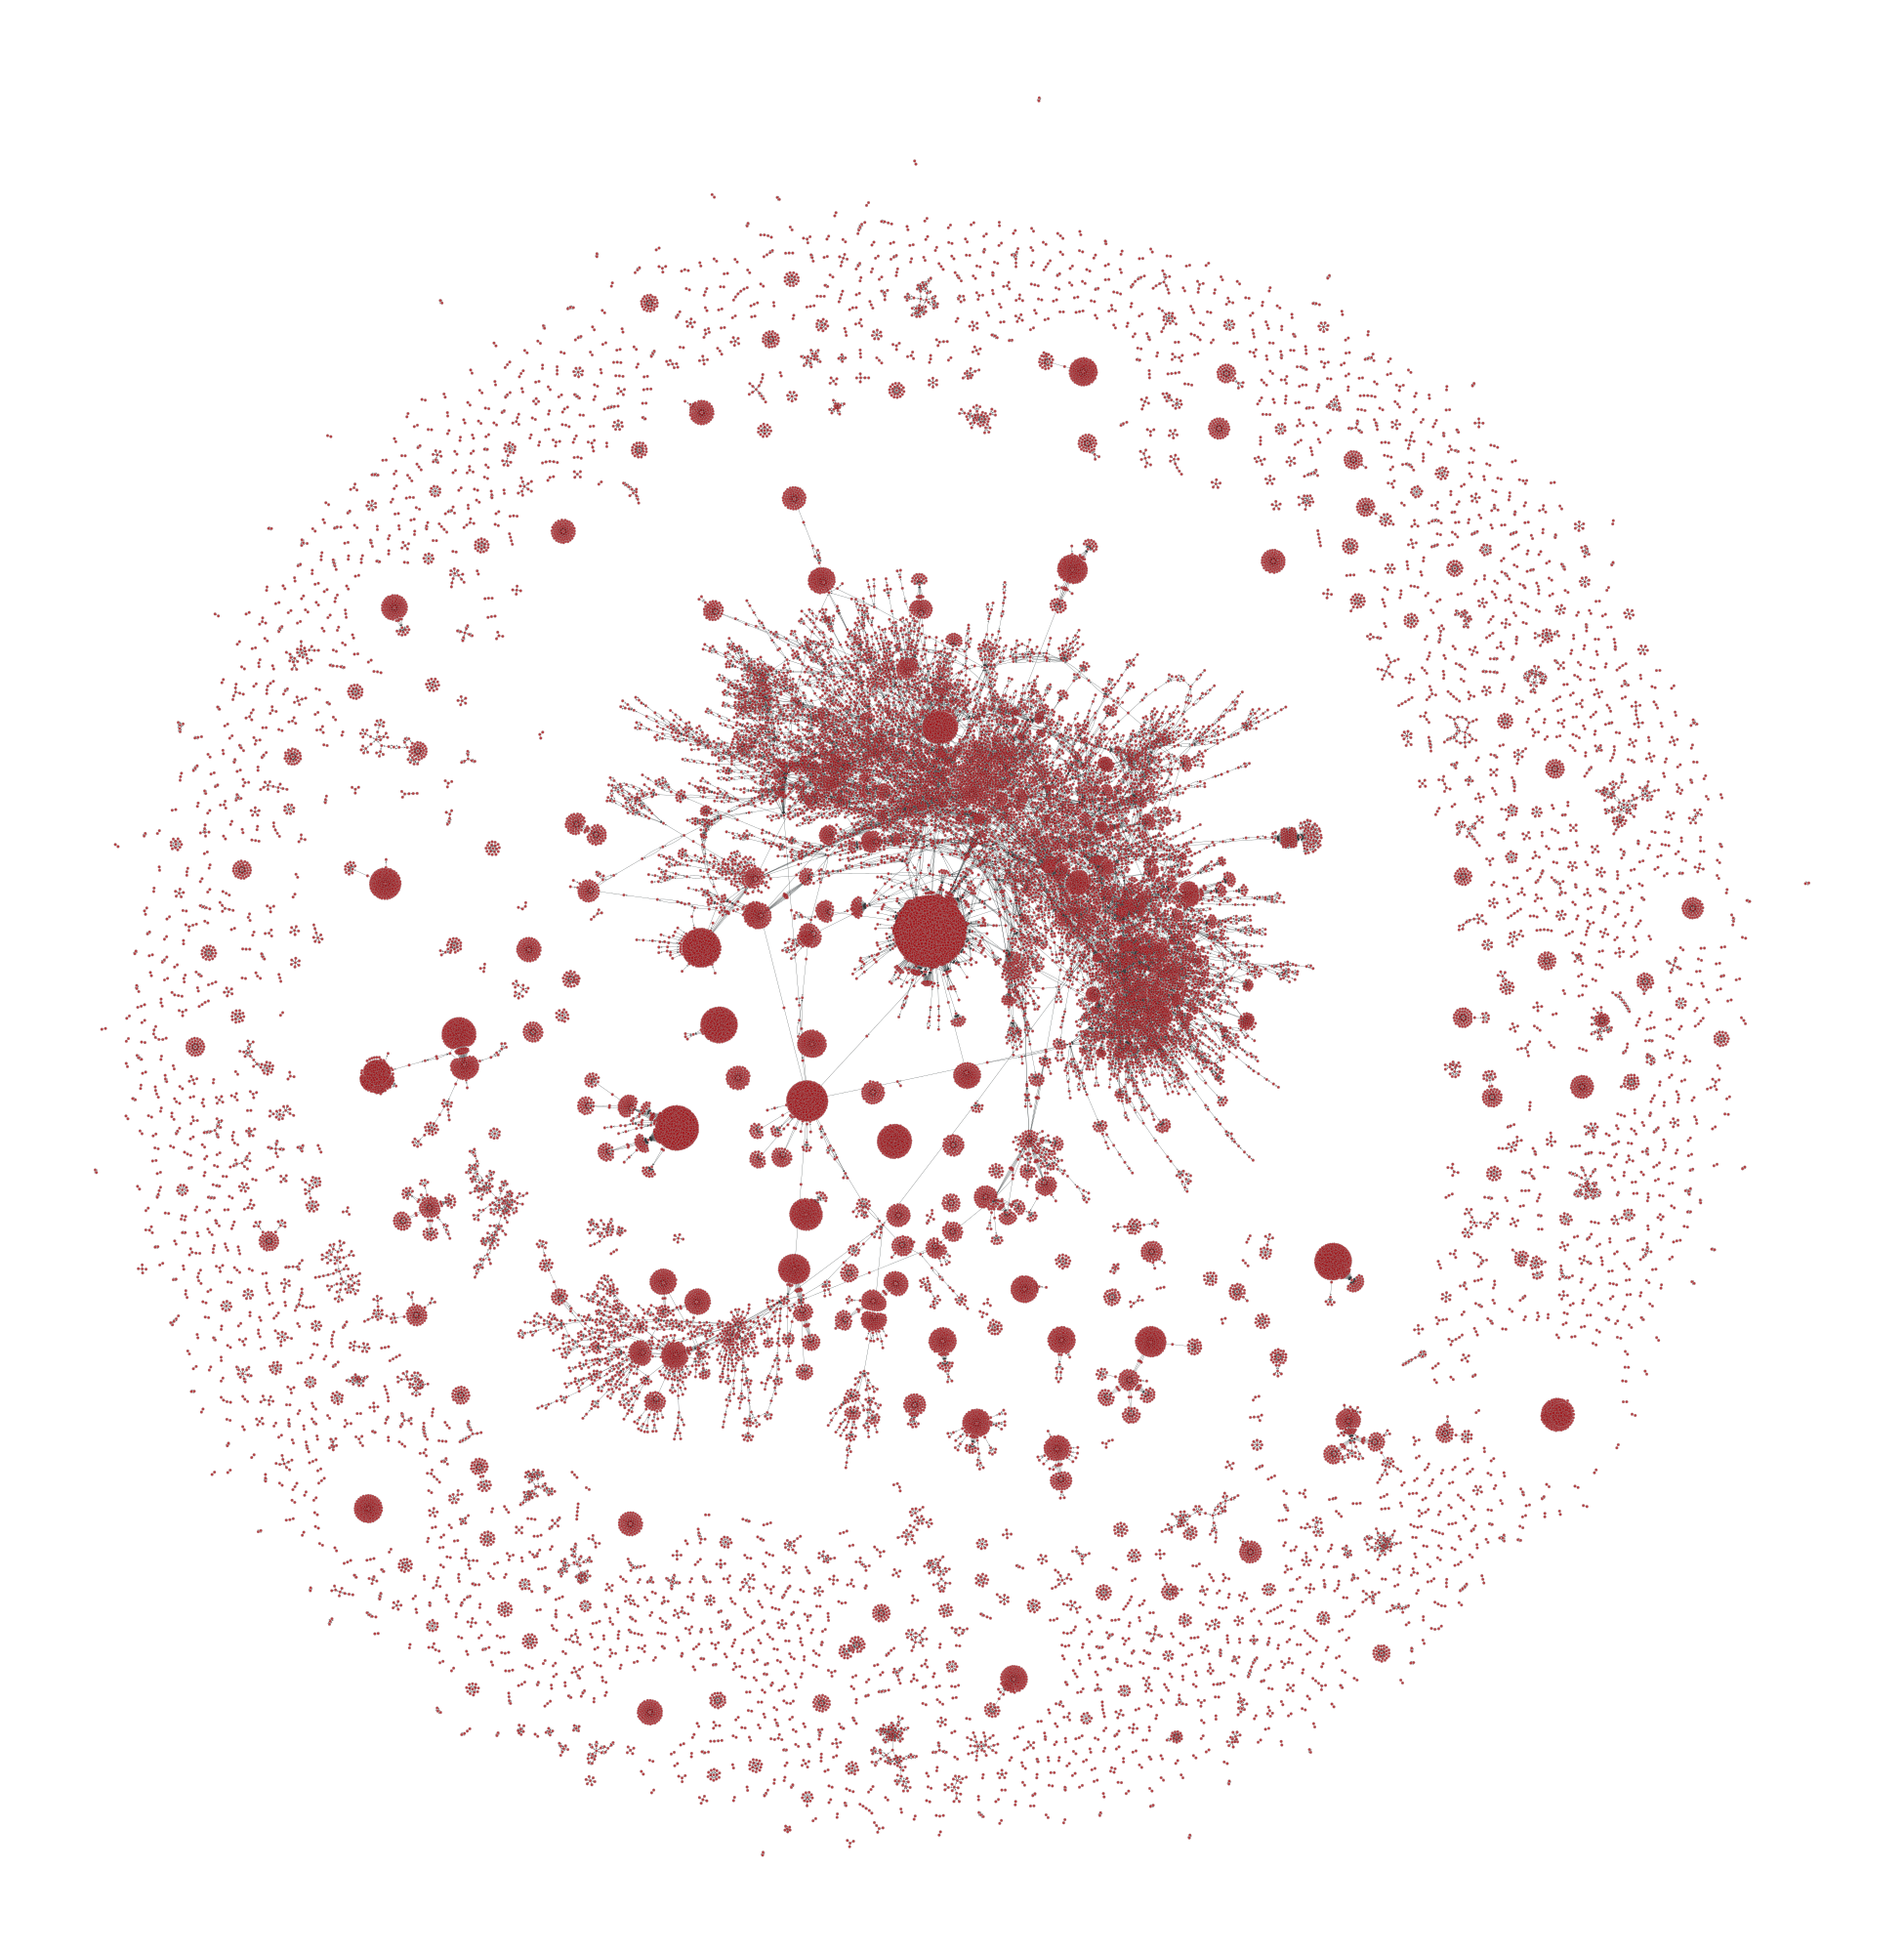

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f84709af370, at 0x7f8450b08af0>

In [29]:
path = os.environ["OUT"] + "/anatomical_structure_graph.gt"
g = load_graph(path)

pos = sfdp_layout(g)
graph_draw(g, pos=pos, output_size=(1000, 1000))